# FaceCheck: AI Detection 
*Author: Andy Shen*

## Overview

In today's digital world, anyone can manipulate images and videos with relative ease. Distinguishing real faces from AI-generated ones has become increasingly crucial. 


FaceCheck is a AI image classifier that is trained on 1000 fake and real images to discern genuine faces from a synthetic one. 

## Business Problem

There is a variety of problems that comes with facial image fabrication.

- Misinformation: Deepfakes can be used to fabricate news or spread fake news for political gain
- Financial fraud: Fake identities can be used to commit identity theft, open fraudulent accounts, and bypass security measures.
- Manipulation: Fake identities can be used to impersonal individuals and deceive audiences

FaceCheck equips individuals with the ability to detect and verify faces. FaceCheck will allow users to:

- Verify the authenticity of online profiles and interactions.
- Protect themselves from online scams and phishing attempts.
- Contribute to a safer and reliable online experience

## Data Understanding

The dataset comes from https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection/ .

In [2]:
## Imports
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras import models
from keras import layers
from keras import optimizers

import random
import cv2

In [3]:
os.listdir('data/')

['training_fake', 'training_real']

In [4]:
#Directory Path
real = "data/training_real/"
fake = "data/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [5]:
categories = ['Real', 'AIGenerated']

### Visualizing Our Data

In [6]:
## function for loading image
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

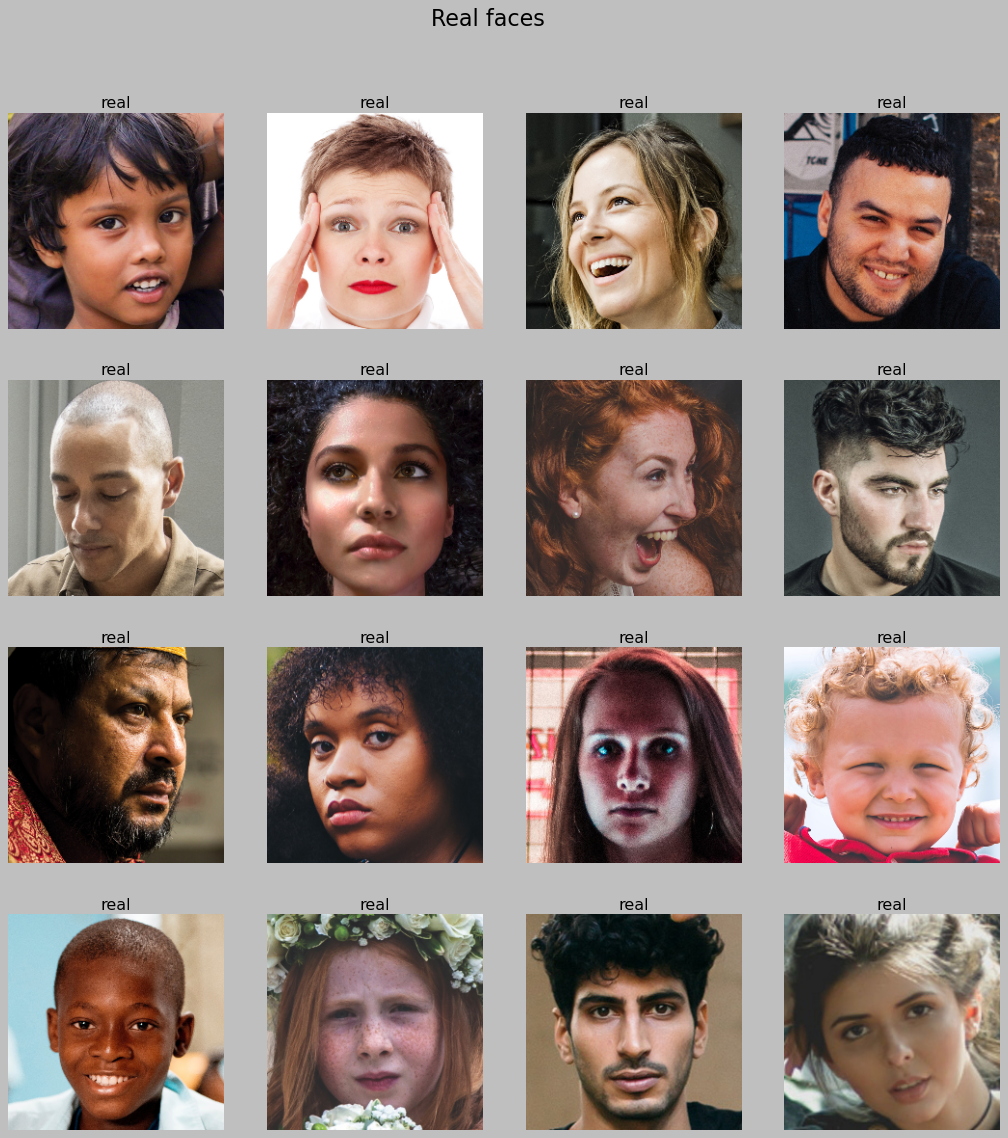

In [54]:
fig = plt.figure(figsize=(16,16))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.title('real')
    plt.axis('off')

plt.show()

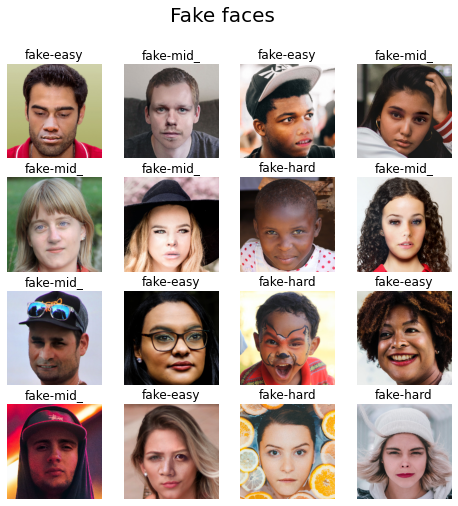

In [8]:
fig = plt.figure(figsize=(8,8))

for i in range(16):
    rand = random.randrange(900)
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i+rand]), cmap='gray')
    plt.suptitle("Fake faces",fontsize=20)
    plt.title('fake-'+ fake_path[i+rand][:4])
    plt.axis('off')

plt.show()

In [9]:
dataset_path = "../AI-Facial-Detection/data/"

In [10]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [11]:
train_generator = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 1633 images belonging to 2 classes.


In [12]:
val_generator = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 408 images belonging to 2 classes.


# Modeling

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D

In [14]:
##function for displaying results graph
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'], loc=3)
    plt.grid(True)
    plt.style.use(['classic'])

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'], loc=3)
    plt.grid(True)
    plt.style.use(['classic'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

### Baseline model

In [18]:
# Callbacks

def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

Our baseline model will be a single Dense layer neural net

In [19]:
model1 = Sequential([
    Flatten(input_shape=(96,96,3)),  # Flatten the 2D image
    Dense(128, activation='relu'),  # Dense layer with 128 neurons
    Dense(10, activation='softmax')  # Output layer with 10 neurons (one for each digit)
])

In [22]:
model1.layers[0].trainable = False
model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 27648)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3539072   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 3,540,362
Trainable params: 3,540,362
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist1 = model1.fit_generator(train_generator,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val_generator)

Epoch 1/20
52/52 [==============================] - 23s 434ms/step - loss: 5.5134 - accuracy: 0.5462 - val_loss: 1.6364 - val_accuracy: 0.5245
Epoch 2/20
52/52 [==============================] - 25s 478ms/step - loss: 2.2677 - accuracy: 0.5658 - val_loss: 1.3464 - val_accuracy: 0.5074
Epoch 3/20
52/52 [==============================] - 28s 534ms/step - loss: 0.9055 - accuracy: 0.6467 - val_loss: 1.1897 - val_accuracy: 0.5074
Epoch 4/20
52/52 [==============================] - 24s 464ms/step - loss: 0.6663 - accuracy: 0.6693 - val_loss: 0.9527 - val_accuracy: 0.5417
Epoch 5/20
52/52 [==============================] - 27s 521ms/step - loss: 0.6312 - accuracy: 0.6877 - val_loss: 0.9751 - val_accuracy: 0.5196
Epoch 6/20
52/52 [==============================] - 22s 432ms/step - loss: 0.6022 - accuracy: 0.6950 - val_loss: 0.9015 - val_accuracy: 0.5637
Epoch 7/20
52/52 [==============================] - 26s 494ms/step - loss: 0.6001 - accuracy: 0.6957 - val_loss: 1.0703 - val_accuracy: 0.5049

### Visualization for Base Model:

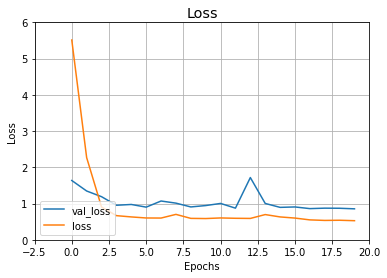

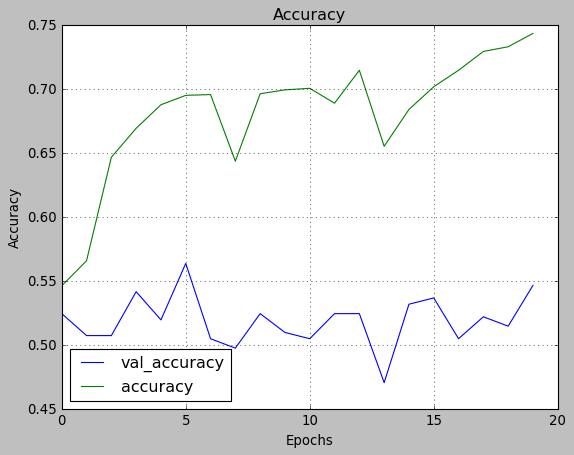

In [24]:
visualize_training_results(hist1)

### MobileNetV2 Model:

In [25]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

In [26]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

In [27]:
tf.keras.backend.clear_session()

model2 = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model2.layers[0].trainable = False

model2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [28]:
hist2 = model2.fit_generator(train_generator,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val_generator)

Epoch 1/20
52/52 [==============================] - 36s 693ms/step - loss: 0.9098 - accuracy: 0.5995 - val_loss: 1.0449 - val_accuracy: 0.5515
Epoch 2/20
52/52 [==============================] - 38s 734ms/step - loss: 0.5700 - accuracy: 0.7171 - val_loss: 0.9149 - val_accuracy: 0.5172
Epoch 3/20
52/52 [==============================] - 36s 693ms/step - loss: 0.4882 - accuracy: 0.7710 - val_loss: 1.0580 - val_accuracy: 0.5147
Epoch 4/20
52/52 [==============================] - 36s 692ms/step - loss: 0.3653 - accuracy: 0.8359 - val_loss: 1.0276 - val_accuracy: 0.5123
Epoch 5/20
52/52 [==============================] - 38s 728ms/step - loss: 0.3434 - accuracy: 0.8438 - val_loss: 1.0822 - val_accuracy: 0.4951
Epoch 6/20
52/52 [==============================] - 37s 717ms/step - loss: 0.3217 - accuracy: 0.8579 - val_loss: 1.0946 - val_accuracy: 0.4902
Epoch 7/20
52/52 [==============================] - 37s 713ms/step - loss: 0.3073 - accuracy: 0.8683 - val_loss: 1.0903 - val_accuracy: 0.4951

### Visualization for MobileNetV2


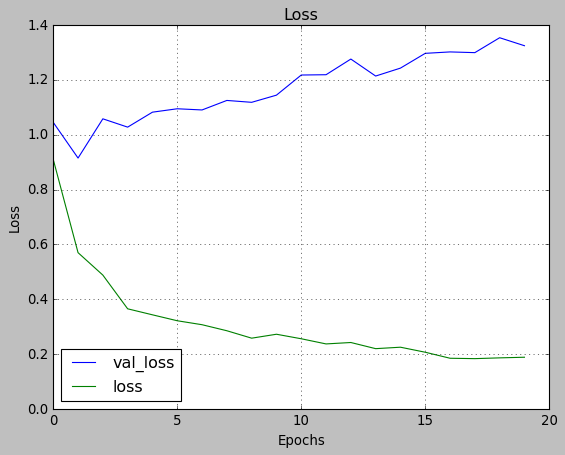

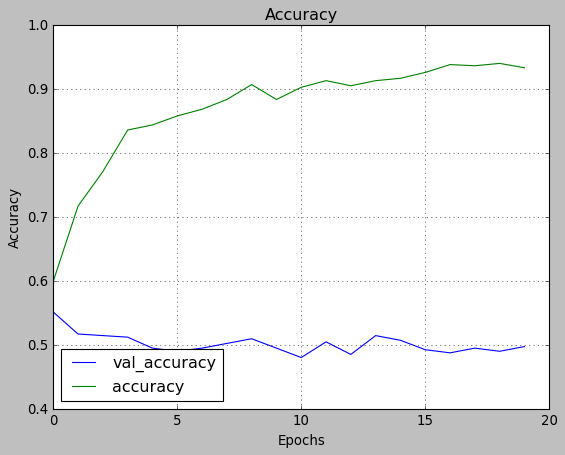

In [29]:
visualize_training_results(hist2)

### VGG16 Model

In [30]:
train_generator = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=98,
                                          subset="training")

val_generator = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [31]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(96,96,3))

In [32]:
model3 = Sequential([vgg16_model,
                    Flatten(),
#                     GlobalAveragePooling2D(),
#                     Dense(512, activation = "relu"),
#                     BatchNormalization(),
#                     Dropout(0.3),
#                     Dense(128, activation = "relu"),
#                     Dropout(0.1),
#                     # Dense(32, activation = "relu"),
#                     # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model3.layers[0].trainable = False

model3.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 9218      
Total params: 14,723,906
Trainable params: 9,218
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
hist3 =  model3.fit_generator(train_generator,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val_generator)

Epoch 1/20
17/17 [==============================] - 57s 3s/step - loss: 0.7590 - accuracy: 0.5187 - val_loss: 0.7045 - val_accuracy: 0.5588
Epoch 2/20
17/17 [==============================] - 51s 3s/step - loss: 0.6407 - accuracy: 0.6338 - val_loss: 0.7118 - val_accuracy: 0.5441
Epoch 3/20
17/17 [==============================] - 48s 3s/step - loss: 0.5958 - accuracy: 0.6699 - val_loss: 0.7134 - val_accuracy: 0.5858
Epoch 4/20
17/17 [==============================] - 49s 3s/step - loss: 0.5698 - accuracy: 0.6969 - val_loss: 0.7083 - val_accuracy: 0.5515
Epoch 5/20
17/17 [==============================] - 48s 3s/step - loss: 0.5677 - accuracy: 0.6889 - val_loss: 0.7234 - val_accuracy: 0.5441
Epoch 6/20
17/17 [==============================] - 48s 3s/step - loss: 0.5614 - accuracy: 0.7055 - val_loss: 0.7264 - val_accuracy: 0.5515
Epoch 7/20
17/17 [==============================] - 49s 3s/step - loss: 0.5636 - accuracy: 0.7122 - val_loss: 0.7083 - val_accuracy: 0.5490
Epoch 8/20
17/17 [==

### Visualization for VGG16

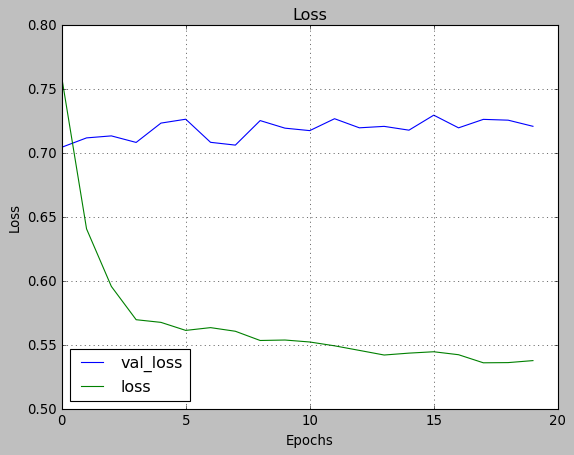

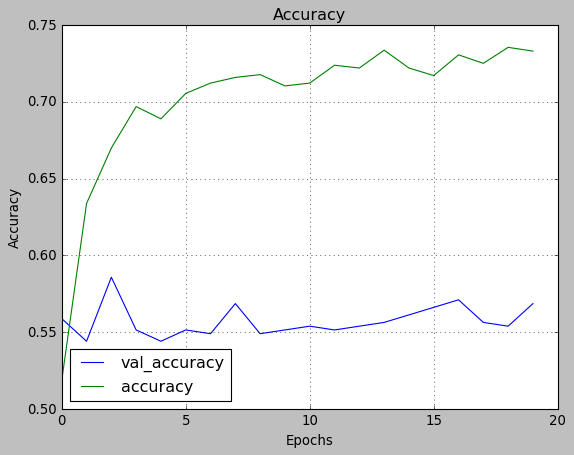

In [35]:
visualize_training_results(hist3)

### Custom Model 1:

In [36]:
model4 = keras.Sequential([
    keras.layers.Conv2D(32,(3,3), activation='relu', input_shape = (96,96,3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64,(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128,(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(256,(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  
])

model4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [37]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)      

In [38]:
hist4 =  model4.fit_generator(train_generator,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val_generator)

Epoch 1/20
17/17 [==============================] - 33s 2s/step - loss: 0.6972 - accuracy: 0.5407 - val_loss: 0.6930 - val_accuracy: 0.5515
Epoch 2/20
17/17 [==============================] - 33s 2s/step - loss: 0.6917 - accuracy: 0.5309 - val_loss: 0.6914 - val_accuracy: 0.5294
Epoch 3/20
17/17 [==============================] - 33s 2s/step - loss: 0.6902 - accuracy: 0.5309 - val_loss: 0.6914 - val_accuracy: 0.5343
Epoch 4/20
17/17 [==============================] - 33s 2s/step - loss: 0.6884 - accuracy: 0.5358 - val_loss: 0.6912 - val_accuracy: 0.5343
Epoch 5/20
17/17 [==============================] - 34s 2s/step - loss: 0.6874 - accuracy: 0.5419 - val_loss: 0.6908 - val_accuracy: 0.5392
Epoch 6/20
17/17 [==============================] - 33s 2s/step - loss: 0.6855 - accuracy: 0.5530 - val_loss: 0.6903 - val_accuracy: 0.5270
Epoch 7/20
17/17 [==============================] - 33s 2s/step - loss: 0.6834 - accuracy: 0.5664 - val_loss: 0.6898 - val_accuracy: 0.5564
Epoch 8/20
17/17 [==

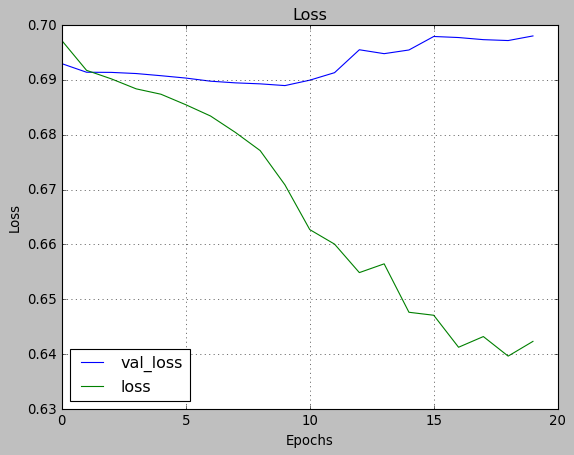

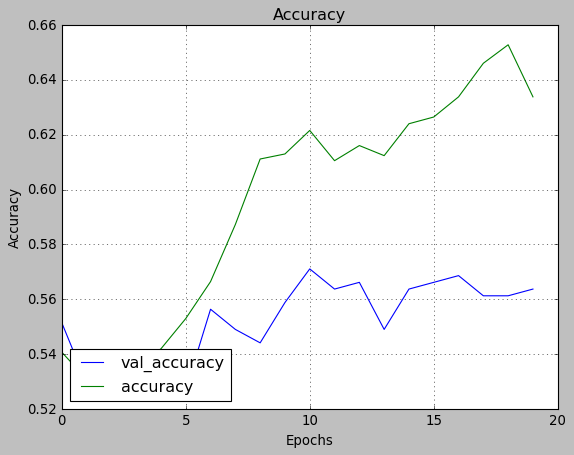

In [39]:
visualize_training_results(hist4)

### Custom Model 2:

In [40]:
Image_Size= 96
Batch_Size = 32
Channels=3
Epochs=10

In [41]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [42]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])


In [43]:
input_shape = (Batch_Size,Image_Size, Image_Size,Channels)
n_classes = 3

In [44]:
model5 = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),
    
])

model5.build(input_shape=input_shape)
model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 60, 60, 64)         

In [45]:
model5.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
hist5 =  model5.fit_generator(train_generator,
                    epochs=10,
                    callbacks=[lr_callbacks],
                    validation_data=val_generator)

Epoch 1/10
17/17 [==============================] - 71s 4s/step - loss: 0.8662 - accuracy: 0.5144 - val_loss: 0.6973 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 72s 4s/step - loss: 0.7057 - accuracy: 0.5052 - val_loss: 0.6935 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 73s 4s/step - loss: 0.7008 - accuracy: 0.4813 - val_loss: 0.6992 - val_accuracy: 0.5294
Epoch 4/10
17/17 [==============================] - 71s 4s/step - loss: 0.6968 - accuracy: 0.5297 - val_loss: 0.6933 - val_accuracy: 0.5294
Epoch 5/10
17/17 [==============================] - 74s 4s/step - loss: 0.6928 - accuracy: 0.5297 - val_loss: 0.6923 - val_accuracy: 0.5294
Epoch 6/10
17/17 [==============================] - 72s 4s/step - loss: 0.6923 - accuracy: 0.5297 - val_loss: 0.6920 - val_accuracy: 0.5294
Epoch 7/10
17/17 [==============================] - 73s 4s/step - loss: 0.6921 - accuracy: 0.5297 - val_loss: 0.6919 - val_accuracy: 0.5294
Epoch 8/10
17/17 [==

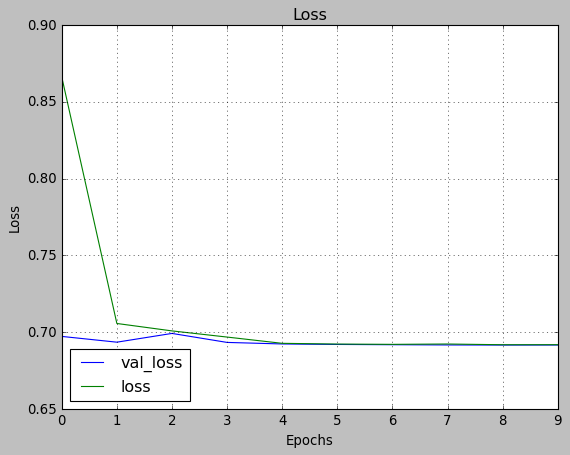

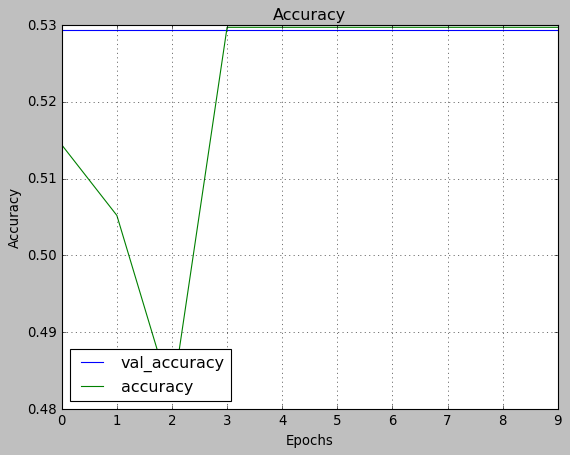

In [48]:
visualize_training_results(hist5)

## Predictions

In [50]:
predictions = model3.predict_generator(val_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [51]:
random.randrange(300)

153

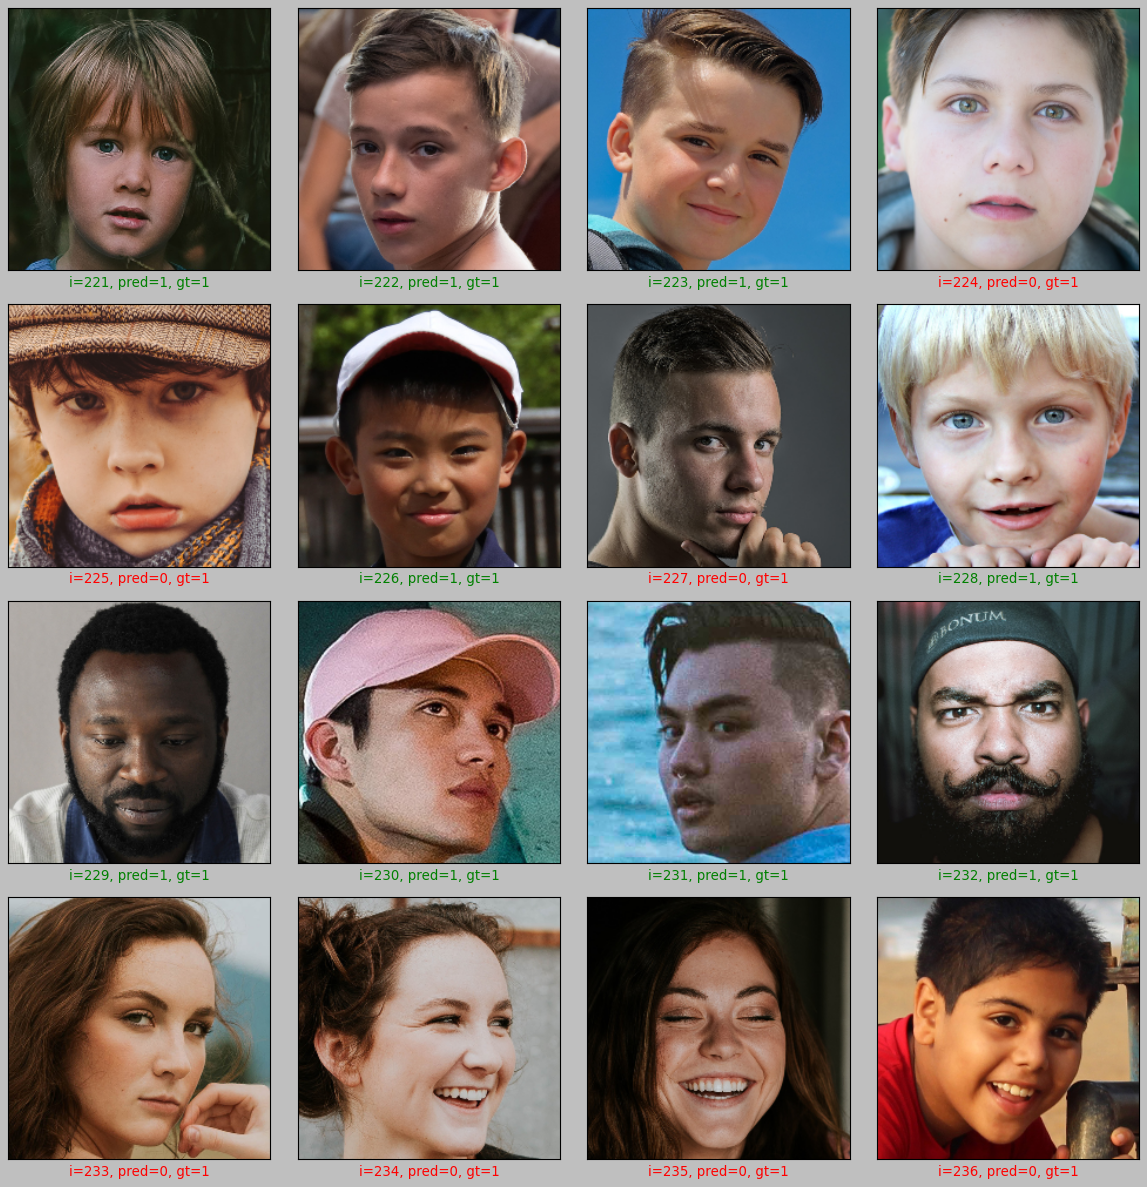

In [52]:
dataset_path
plt.figure(figsize=(15,15))

start_index = random.randrange(408)

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index+i]])
    
  gt = val_generator.filenames[start_index+i][9:13]

  
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(dataset_path+val_generator.filenames[start_index+i]))
  plt.tight_layout()

plt.show()

## Future Steps

Although testing accuracy has increased with different model tuning, the validation/testing accuracy is barely above 50%. 

We can:
- Increase training and testing data
- Continue to fine tune models

Future plans:  
- Connect a front end app that allows users to upload a picture and get feedback immediately